In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayushkumarsamal","key":"2605616fd4f8b517b5127c3e2594b66a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: ./chest_xray/train/NORMAL/

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray/train",
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray/val",
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray/test",
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [6]:
base_model = applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                      include_top=False,
                                      weights="imagenet")
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=3)


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.8790 - loss: 0.2547 - val_accuracy: 0.6875 - val_loss: 0.4214
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9634 - loss: 0.1012 - val_accuracy: 0.7500 - val_loss: 0.3608
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9709 - loss: 0.0805 - val_accuracy: 0.8125 - val_loss: 0.4194


In [7]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7810 - loss: 0.5930
Test Accuracy: 0.78


In [16]:

base_model = applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                      include_top=False,
                                      weights="imagenet")
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)


In [19]:
def get_gradcam_heatmap(model, image_array, last_conv_layer_name="Conv_1"):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [20]:
def display_gradcam(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = normalization_layer(img_array)

    preds = model.predict(img_array)
    class_label = "PNEUMONIA" if preds[0][0] > 0.5 else "NORMAL"

    heatmap = get_gradcam_heatmap(model, img_array)

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * 0.4 + img_array[0].numpy() * 255
    plt.imshow(np.uint8(superimposed_img))
    plt.title(f"Prediction: {class_label} ({preds[0][0]:.2f})")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


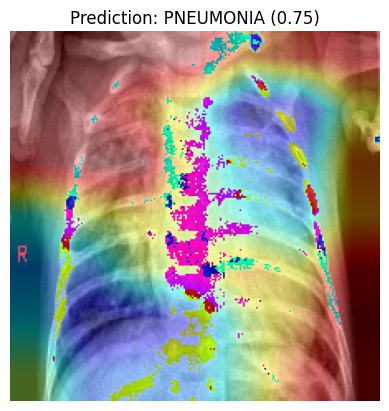

In [21]:
display_gradcam("chest_xray/test/PNEUMONIA/person136_bacteria_648.jpeg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


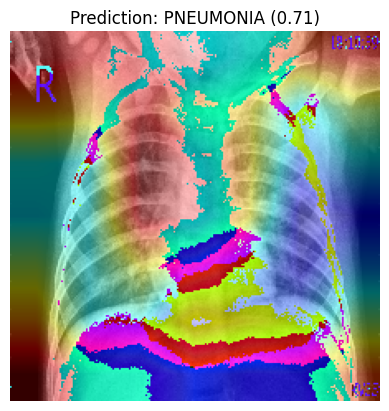

In [23]:
display_gradcam("chest_xray/test/PNEUMONIA/person28_virus_62.jpeg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


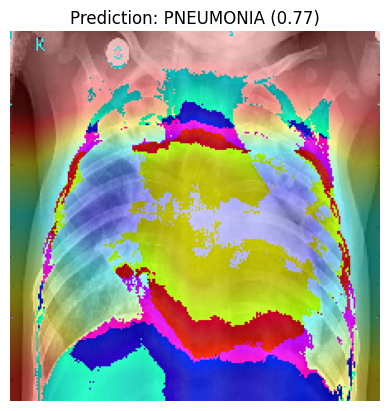

In [24]:
display_gradcam("chest_xray/test/PNEUMONIA/person87_bacteria_434.jpeg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


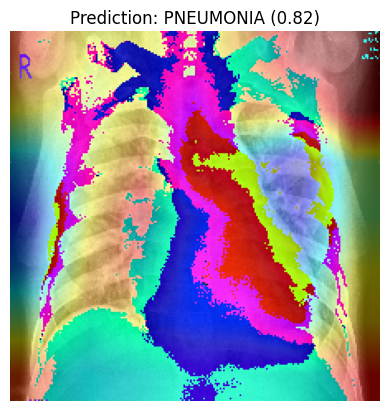

In [25]:
display_gradcam("chest_xray/test/PNEUMONIA/person21_virus_52.jpeg", model)

['person136_bacteria_648.jpeg', 'person28_virus_62.jpeg', 'person87_bacteria_434.jpeg', 'person1649_virus_2850.jpeg', 'person21_virus_52.jpeg']
